# COMP47670 Assignment 2 - Text Classification

#### Student Name: Dara Leonard
#### Student ID: 19202478

In [395]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, \
    classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split


### Task 1: Scrape all reviews for each category and store them as three separate datasets
For Task 1 I have chosen the Automotive, Cafes, Fashion categories as my data sources.

The following four methods extract the review data from the data source (Yalp) and extracts it out into three pandas
data frames, one for each of the chosen categories. 

In [396]:
from sklearn.naive_bayes import MultinomialNB
data_source = 'http://mlg.ucd.ie/modules/yalp/'
business_categories = ['automotive_list.html', 'cafes_list.html', 'fashion_list.html']

def extract_category_data(url):
    response = requests.get(url)
    data = response.text
    return BeautifulSoup(data,'html.parser')


def categorise_rating(review_stars):
    return 'positive' if int(review_stars.get('alt').split('-')[0]) >= 4 else 'negative'


def extract_reviews(url):
    soup = extract_category_data(url)
    reviews_block = soup.findAll("div", { "class" : "review" })
    review_list =[]
    review_info_columns = ['comment', 'rating']
    review_df = pd.DataFrame(columns=review_info_columns)

    for i, reviews in enumerate(reviews_block):
        review = {}
        review_stars = reviews.find('img')
        review["comments"] = reviews.find("p", { "class" : "review-text" }).get_text()
        review["rating"] = categorise_rating(review_stars)
        review_list.append(review)        
        
        review_tmp = dict({
            'comment': reviews.find("p", { "class" : "review-text" }).get_text(),
            'rating' : categorise_rating(review_stars)
        })
        review_df.loc[i] = review_tmp

    return review_list, review_df


def extract_data(url):
    soup = extract_category_data(url)
    links = soup.find_all('a')
    review_list =[]
    for link in links:
        url = data_source + link.get('href')
        review, review_df = extract_reviews(url)
        review_list.append(review_df)
    return pd.concat(review_list)


automotive_url = data_source + business_categories[0]
cafe_url = data_source + business_categories[1]
fashion_url = data_source + business_categories[2]

automotive_reviews_df = extract_data(automotive_url)
cafe_reviews_df = extract_data(cafe_url)
fashion_reviews_df = extract_data(fashion_url)

The following chunk of logic is dumping the data out to a json file. This will allow the program to be ran in a shorter
amount of time by just reading the already collected data and performing the analysis. 

In [397]:
automotive_reviews_df.to_json('automotive.json', orient='records')
cafe_reviews_df.to_json('cafe.json', orient='records')
fashion_reviews_df.to_json('fashion.json', orient='records')

Re-read the data from the data already collected from Yalp

In [398]:
consolidated_automotive_reviews_df = pd.read_json('automotive.json', orient='records')
consolidated_cafe_reviews_df = pd.read_json('cafe.json', orient='records')
consolidated_fashion_reviews_df = pd.read_json('fashion.json', orient='records')

Display a snapshot of each of the data frames

In [399]:
consolidated_automotive_reviews_df.head()

,comment,rating
0,The man that was working tonight (8-12-17) was...,negative
1,Chris is a very rude person. Gave me an attitu...,negative
2,One of my favorite gas station to stop at. The...,positive
3,Oh thank Heaven for Seven Eleven! I don't know...,negative
4,Five stars because of the guy who works weekda...,positive


In [400]:
consolidated_cafe_reviews_df.head()

,comment,rating
0,Pros: Lots of items you would not expect from ...,positive
1,Best egg-tarts in town! There's really not muc...,positive
2,I've been to ABC Bakery a few times since I re...,negative
3,"FYI, Closed Monday's New ownership for about 1...",negative
4,The inside may not look like much but they mak...,positive


In [401]:
consolidated_fashion_reviews_df.head()

,comment,rating
0,Looking for the best tactical supplies? Look n...,positive
1,Stood in line like an idiot for 5 minutes to p...,negative
2,Another great store with quality Equipment. Th...,positive
3,The Problem with this store is not that they h...,positive
4,Great place! We went in at almost closing time...,positive


Check to see the dimensions of each of the data frames

In [402]:
consolidated_automotive_reviews_df.shape

(2000, 2)

In [403]:
consolidated_cafe_reviews_df.shape

(2000, 2)

In [404]:
consolidated_fashion_reviews_df.shape

(2000, 2)

Do a check to see if there's any missing data

In [405]:
consolidated_automotive_reviews_df.isnull().sum()

comment    0
rating     0
dtype: int64

In [406]:
consolidated_cafe_reviews_df.isnull().sum()

comment    0
rating     0
dtype: int64

In [407]:
consolidated_fashion_reviews_df.isnull().sum()

comment    0
rating     0
dtype: int64

Do a check on the nature of the reviews to see the ratio of positive to negative

In [408]:
consolidated_automotive_reviews_df.groupby('rating')['rating'].count()

rating
negative     788
positive    1212
Name: rating, dtype: int64

In [409]:
consolidated_cafe_reviews_df.groupby('rating')['rating'].count()

rating
negative     538
positive    1462
Name: rating, dtype: int64

In [410]:
consolidated_fashion_reviews_df.groupby('rating')['rating'].count()

rating
negative     795
positive    1205
Name: rating, dtype: int64

### Task 2: For each of the chose categories; apply any necessary pre-processing, build a classification model & test said classification model


##### 2.1 Normalise Data 
The following five methods are tasked with pre-processing the data:
1. remove_stop_words - Remove the stopwords in the review like 'is', 'an', etc. They do not contribute to the efficiency of the classifier
2. remove_numeric_special - Remove any special and numeric characters
3. converted_strings_to_lowercase - convert all characters in every review to lower case
4. lemmatize - Sort words in each review so as to group together inflected or variant forms of the same word.
5. preprocess_data_frame - Calls each of the methods specified above

In [411]:
def remove_stop_words(data_frame):
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    data_frame['comment']=data_frame['comment'].apply(lambda s:  pattern.sub('', s) if len(s)>0 else s ) 
    
    return data_frame


def remove_numeric_special(data_frame):
    data_frame['comment']=data_frame['comment'].apply(lambda s:  re.sub('[^A-Za-z]+', ' ', s)  if len(s)>0 else s ) 
    return data_frame 


def converted_strings_to_lowercase(data_frame):
    data_frame['comment']=data_frame['comment'].str.lower()
    return data_frame 

def lemmatize(data_frame):
    lemmatizer = WordNetLemmatizer()       
    data_frame['comment'] = data_frame['comment'].apply(lambda x: ''.join([lemmatizer.lemmatize(i) for i in x])) 
    return data_frame


def preprocess_data_frame(data_frame):
    preprocessed_data_frame = remove_stop_words(data_frame)
    preprocessed_data_frame = remove_numeric_special(preprocessed_data_frame)
    preprocessed_data_frame = converted_strings_to_lowercase(preprocessed_data_frame)
    return lemmatize(preprocessed_data_frame)



##### 2.2 Merging the dataset to build the classifier

Merging the three data sets to form a unified dataset before normailising the data using the functions written in Task 2.1.

In [412]:
combined_data_frame = consolidated_automotive_reviews_df.append(consolidated_cafe_reviews_df).append(consolidated_fashion_reviews_df)

# NOTE: Compare classification accuracy with and without pre-processing
cleaned_combined_data = preprocess_data_frame(combined_data_frame)

Get a description of the data to see counts, unique count etc.

In [413]:
cleaned_combined_data.describe()

,comment,rating
count,6000,6000
unique,6000,2
top,this place conveniently located one side islan...,positive
freq,1,3879


Preview the new data set to see all words have been normalised

In [414]:
cleaned_combined_data.head()

,comment,rating
0,the man working tonight rude a real jerk i nee...,negative
1,chris rude person gave attitude change some pe...,negative
2,one favorite gas station stop the store always...,positive
3,oh thank heaven seven eleven i know i thank se...,negative
4,five stars guy works weekday mornings around a...,positive


##### 2.3 Choosing the classifier
Let's run some quick experiments to see which of the three available classifiers are the most accurate on one of the data sets.
I am using the automotive category only in these experiments

###### 2.3.1 Logistic Regression

Create a TfidfVectorizer to create a numeric representation of the dataset and set the target value for the classifier

In [415]:
tfidf_vectorizer = TfidfVectorizer()
corpus = cleaned_combined_data['comment']
X_merged = tfidf_vectorizer.fit_transform(corpus)
y_merged = cleaned_combined_data['rating']
X_merged.shape

(6000, 18910)

Now we split the data to use the automotive category data to build the experimental models

In [416]:
X_automotiveReviewSize = consolidated_automotive_reviews_df.shape[0]
X_automotive = X_merged[:X_automotiveReviewSize]
target_automotive = y_merged[:X_automotiveReviewSize]

Identify the dimensions of the separated data set to ensure they match what they were previously

In [417]:
X_automotive.shape

(2000, 18910)

Partition the data to use for the classifier. We use a split of 70% training and 30% test data

In [418]:
automotive_data_train, automotive_data_test, automotive_target_train, automotive_target_test = train_test_split(X_automotive, target_automotive, test_size=0.3, shuffle=True)

Display the shapes of the training and testing data sets 

In [419]:
print("Automotive training data set size: %d" % automotive_data_train.shape[0])
print("Automotive test data set size: %d " % automotive_data_test.shape[0])

Automotive training data set size: 1400
Automotive test data set size: 600 


Train each of the model using each of the training data set

In [420]:
automotive_model_log_reg = linear_model.LogisticRegression(solver='liblinear')
automotive_model_log_reg.fit(automotive_data_train, automotive_target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

After training the model above, we can now use our test data to evaluate the model.

First we can produce a confusion matrix

In [421]:
predicted_automotive_log_reg = automotive_model_log_reg.predict(automotive_data_test)
automotive_confusion_matrix_log_reg = confusion_matrix(automotive_target_test, predicted_automotive_log_reg, labels=['positive','negative'])
print(automotive_confusion_matrix_log_reg)

[[352  16]
 [ 46 186]]


Now we can get the accuracy score, precision, recall and F-score of the logistic regression model

In [422]:
automotive_log_reg_model_accuracy = accuracy_score(automotive_target_test, predicted_automotive_log_reg)
print("Accuracy of the Logistic Regression model: %.2f" % automotive_log_reg_model_accuracy)
# We are interested in the Positive class here
print("Precision (Positive): %.2f" % precision_score(automotive_target_test, predicted_automotive_log_reg, pos_label='positive') )
print("Recall (Positive): %.2f" % recall_score(automotive_target_test, predicted_automotive_log_reg, pos_label='positive') )
print("F1 (Positive): %.2f" % f1_score(automotive_target_test, predicted_automotive_log_reg, pos_label='positive') )

Accuracy of the Logistic Regression model: 0.90
Precision (Positive): 0.88
Recall (Positive): 0.96
F1 (Positive): 0.92


We can get the summary statistics of the model using scikit-learn's built in classification_report method

In [423]:
print(classification_report(automotive_target_test, predicted_automotive_log_reg, target_names=["negative","positive"]))

              precision    recall  f1-score   support

    negative       0.92      0.80      0.86       232
    positive       0.88      0.96      0.92       368

    accuracy                           0.90       600
   macro avg       0.90      0.88      0.89       600
weighted avg       0.90      0.90      0.90       600



Finally we can perform 10-Fold Cross Validation on the model to test its accuracy

In [424]:
automotive_model_cross_validation_score_log_reg =  cross_val_score(automotive_model_log_reg, X_automotive, target_automotive, cv=10, scoring="accuracy")
print("Mean cross-validation accuracy of the logistic regression model: %.2f" % automotive_model_cross_validation_score_log_reg.mean())

Mean cross-validation accuracy of the logistic regression model: 0.89


###### 2.3.2 Naive Bayes

Build a Naive Bayes model with the same training data as used in the logistic regression classifier

In [425]:
automotive_model_naive_bayes = MultinomialNB().fit(automotive_data_train, automotive_target_train)

After training the model, we can again use our test data to evaluate the model and produce a confusion matrix

In [426]:
predicted_automotive_naive_bayes = automotive_model_naive_bayes.predict(automotive_data_test)

automotive_confusion_matrix_naive_bayes = confusion_matrix(automotive_target_test, predicted_automotive_naive_bayes, labels=['positive','negative'])
print(automotive_confusion_matrix_naive_bayes)

[[366   2]
 [140  92]]


Using the same methods as above, we can get the accuracy score, precision, recall and F-score of the Naive Bayes model

In [427]:
automotive_model_accuracy_naive_bayes = accuracy_score(automotive_target_test, predicted_automotive_naive_bayes)
print("Accuracy of the Naive Bayes model: %.2f" % automotive_model_accuracy_naive_bayes)
# We are interested in the Positive class here
print("Precision (Positive): %.2f" % precision_score(automotive_target_test, predicted_automotive_naive_bayes, pos_label='positive') )
print("Recall (Positive): %.2f" % recall_score(automotive_target_test, predicted_automotive_naive_bayes, pos_label='positive') )
print("F1 (Positive): %.2f" % f1_score(automotive_target_test, predicted_automotive_naive_bayes, pos_label='positive') )

Accuracy of the Naive Bayes model: 0.76
Precision (Positive): 0.72
Recall (Positive): 0.99
F1 (Positive): 0.84


We can get the summary statistics of the model using scikit-learn's built in classification_report method

In [428]:
print(classification_report(automotive_target_test, predicted_automotive_naive_bayes, target_names=["negative","positive"]))

              precision    recall  f1-score   support

    negative       0.98      0.40      0.56       232
    positive       0.72      0.99      0.84       368

    accuracy                           0.76       600
   macro avg       0.85      0.70      0.70       600
weighted avg       0.82      0.76      0.73       600



Finally we can perform 10-Fold Cross Validation on the model to test its accuracy

In [429]:
automotive_model_cross_validation_score_naive_bayes =  cross_val_score(automotive_model_naive_bayes, X_automotive, target_automotive, cv=10, scoring="accuracy")
print("Mean cross-validation accuracy of the Naive Bayes model: %.2f" % automotive_model_cross_validation_score_naive_bayes.mean())

Mean cross-validation accuracy of the Naive Bayes model: 0.77


###### 2.3.3 Random Forests
Build a Random Forests model with the same training data as used in the logistic regression and naive bayes classifiers above

To get the best results from the random forests model we should do some parameter tuning. To do this we can use GridSearchCV
to tune the hyper parameters

In [430]:
random_forest = RandomForestClassifier()

random_forest_param_grid = {
    'bootstrap': [True],
    'max_depth': [30, 40, 50],
    'n_estimators': [100, 200, 300, 500]
}

grid_search = GridSearchCV(estimator = random_forest, param_grid = random_forest_param_grid, n_jobs = -1, verbose = 2)
grid_search.fit(automotive_data_train, automotive_target_train) 

automotive_model_score_random_forest = grid_search.best_estimator_
automotive_model_score_random_forest.fit(automotive_data_test, automotive_target_test) 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.3min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

After training the model, we can again use our test data to evaluate the model and produce a confusion matrix

In [431]:
predicted_automotive_random_forest = automotive_model_score_random_forest.predict(automotive_data_test)

automotive_confusion_matrix_random_forest = confusion_matrix(automotive_target_test, predicted_automotive_random_forest, labels=['positive','negative'])
print(automotive_confusion_matrix_random_forest)

[[368   0]
 [  0 232]]


Using the same methods as above, we can get the accuracy score, precision, recall and F-score of the Random Forest model

In [432]:
automotive_model_accuracy_random_forest = accuracy_score(automotive_target_test, predicted_automotive_random_forest)
print("Accuracy of the Random Forests model: %.2f" % automotive_model_accuracy_random_forest)
# We are interested in the Positive class here
print("Precision (Positive): %.2f" % precision_score(automotive_target_test, predicted_automotive_random_forest, pos_label='positive') )
print("Recall (Positive): %.2f" % recall_score(automotive_target_test, predicted_automotive_random_forest, pos_label='positive') )
print("F1 (Positive): %.2f" % f1_score(automotive_target_test, predicted_automotive_random_forest, pos_label='positive') )

Accuracy of the Random Forests model: 1.00
Precision (Positive): 1.00
Recall (Positive): 1.00
F1 (Positive): 1.00


We can get the summary statistics of the model using scikit-learn's built in classification_report method

In [433]:
print(classification_report(automotive_target_test, predicted_automotive_random_forest, target_names=["negative","positive"]))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       232
    positive       1.00      1.00      1.00       368

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



Finally we can perform 10-Fold Cross Validation on the model to test its accuracy

In [434]:
automotive_model_cross_validation_score_random_forest =  cross_val_score(automotive_model_score_random_forest, X_automotive, target_automotive, cv=10, scoring="accuracy")
print("Mean cross-validation accuracy of the Random Forests model: %.2f" % automotive_model_cross_validation_score_random_forest.mean())


Mean cross-validation accuracy of the Random Forests model: 0.85


Now we can plot the accuracy of each of the models

I have chosen 10-fold cross validation as the classification evaluation metric as it trains and tests on all data in the data set.

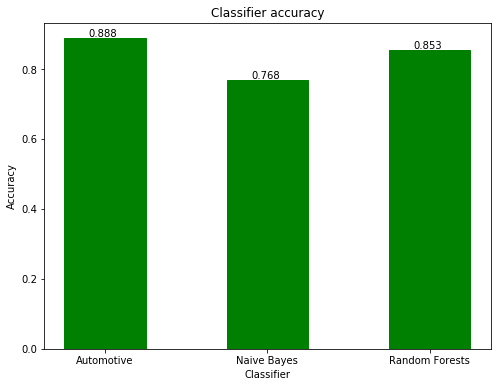

In [437]:
accuracy_results = [automotive_model_cross_validation_score_log_reg.mean(), automotive_model_cross_validation_score_naive_bayes.mean(), automotive_model_cross_validation_score_random_forest.mean()]
index = np.arange(len(accuracy_results))
plt.figure(figsize=(8,6))
bar_list = plt.bar(index, accuracy_results, width=0.5)
for bar in bar_list:
    yval = round(bar.get_height(), 3)
    plt.text(bar.get_x()+0.15, yval + .005, yval)

bar_list[0].set_color('g')
bar_list[1].set_color('g')
bar_list[2].set_color('g')

plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.xticks(index, ["Automotive", "Naive Bayes", "Random Forests"])
plt.title('Classifier accuracy')
plt.show()

From the results above, the logistic regression model has a slightly better accuracy than the one built using random forests

##### 2.3 Building each of the logistic regression models using each of the chosen categories

First we have to extract the cafe and fashion data from the merged data set

In [438]:
X_cafeReviewSize = consolidated_cafe_reviews_df.shape[0]
X_fashionReviewSize = consolidated_fashion_reviews_df.shape[0]

X_cafe = X_merged[X_automotiveReviewSize:X_automotiveReviewSize + X_cafeReviewSize]
target_cafe = y_merged[X_automotiveReviewSize:X_automotiveReviewSize + X_cafeReviewSize]

X_fashion = X_merged[X_automotiveReviewSize + X_cafeReviewSize:]
target_fashion = y_merged[X_automotiveReviewSize + X_cafeReviewSize:]


Then we do a quick inspection of each of these data sets to ensure they are the correct size

In [439]:
X_cafe.shape

(2000, 18910)

In [440]:
X_fashion.shape

(2000, 18910)

We can then build the model for each of the other two categories

In [448]:
cafe_data_train, cafe_data_test, cafe_target_train, cafe_target_test = train_test_split(X_cafe, target_cafe, test_size=0.3, shuffle=True)
fashion_data_train, fashion_data_test, fashion_target_train, fashion_target_test = train_test_split(X_fashion, target_fashion, test_size=0.3, shuffle=True)

cafe_model_log_reg = linear_model.LogisticRegression(solver='liblinear')
cafe_model_log_reg.fit(cafe_data_train, cafe_target_train)

fashion_model_log_reg = linear_model.LogisticRegression(solver='liblinear')
fashion_model_log_reg.fit(fashion_data_train, fashion_target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [445]:
automotive_model_cross_validation_score_log_reg =  cross_val_score(automotive_model_log_reg, X_automotive, target_automotive, cv=10, scoring="accuracy")
print("Mean cross-validation accuracy of the logistic regression model - automotive: %.2f" % automotive_model_cross_validation_score_log_reg.mean())

cafe_model_cross_validation_score_log_reg =  cross_val_score(cafe_model_log_reg, X_cafe, target_cafe, cv=10, scoring="accuracy")
print("Mean cross-validation accuracy of the logistic regression model - cafe: %.2f" % cafe_model_cross_validation_score_log_reg.mean())

fashion_model_cross_validation_score_log_reg =  cross_val_score(fashion_model_log_reg, X_fashion, target_fashion, cv=10, scoring="accuracy")
print("Mean cross-validation accuracy of the logistic regression model - fashion: %.2f" % fashion_model_cross_validation_score_log_reg.mean())

Mean cross-validation accuracy of the logistic regression model - automotive: 0.89
Mean cross-validation accuracy of the logistic regression model - cafe: 0.82
Mean cross-validation accuracy of the logistic regression model - fashion: 0.85


### Task 3: Evaluate the performance of each classification model when applied to data from the other two selected categories.

We now have our three models - automotive_model_log_reg, cafe_model_log_reg, fashion_model_log_reg, we can set about Task 3.

##### 2.1 Training on automotive data and evaluating on cafe and fashion data

##### 2.2 Training on cafe data and evaluating on automotive and fashion data
##### 2.3 Training on fashion data and evaluating on automotive and cafe data

In [ ]:
print('Done')